# IS318 - Machine Learning
## TP2 - Linear classification

The goal of this TP is to experiment with linear models for classification.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs, make_classification

from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas

### 1. Dataset

We will work with a synthetic binary classification dataset:

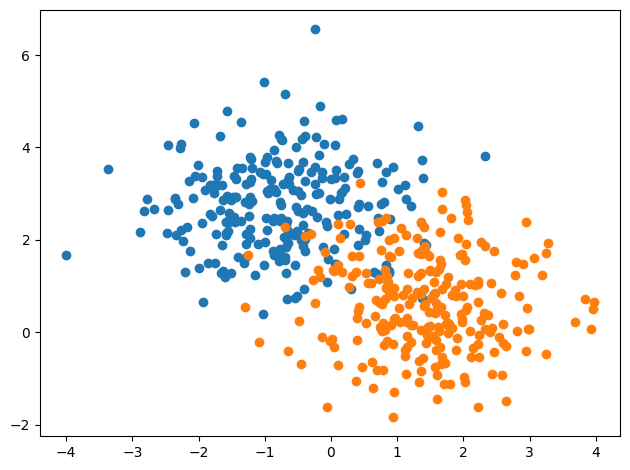

In [95]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, center_box=(-3, 3), random_state=42) # Easy
# X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2) # Harder
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0])
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1])
plt.tight_layout()

Before implementing a classification method, we will apply some preprocessing steps.

**(Question)** Preprocessing: normalize the data such that it has zero mean and unit variance. To do that, for each feature, substract the mean and divide by the standard deviation over the samples.

This procedure is called *standardization*.
It is useful for numerical stability (notably for gradient descent).

In [96]:
X[:, 0] -= np.mean(X[:, 0])
X[:, 0] /= np.std(X[:, 0])

X[:, 1] -= np.mean(X[:, 1])
X[:, 1] /= np.std(X[:, 1])

In [97]:
assert np.allclose(X.mean(axis=0), 0.)
assert np.allclose(X.var(axis=0), 1.)

**(Question)** Plot the data points as above to observe the difference of standardization.

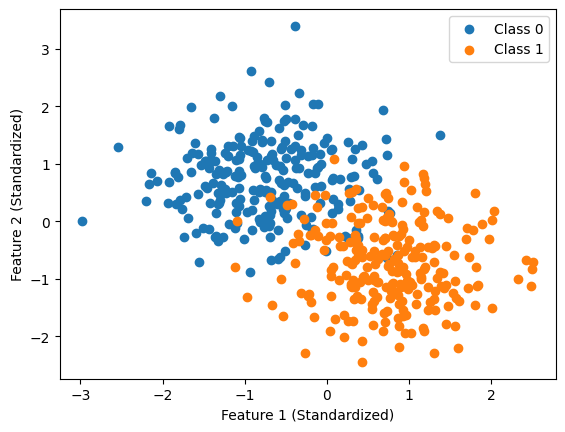

In [98]:
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label="Class 0")
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label="Class 1")

plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

After standardization, we observe the same shape as before, but centered around $0$ for each feature (representing the mean equals to $0$) and with a variance that is reduced to $1$. This change of scale does not have any impact on the shape of the distribution and the relative position of the data, which are the same as initially. 

**(Question)** As usual, add a column with ones to simplify dot product notation. Then, split the dataset into training and validation sets.

In [99]:
X = np.column_stack((np.ones(X.shape[0]), X))
pairs = np.column_stack((X, y))
np.random.shuffle(pairs)
X_permuted, y_permuted = pairs[:, :-1], pairs[:, -1]

split = int(X.shape[0] * 0.75)

X_train = X_permuted[:split]
y_train = y_permuted[:split]

X_valid = X_permuted[split:]
y_valid = y_permuted[split:]

In [100]:
assert X.shape[1] == 3
assert np.all(X[:, 0] == 1.)

**(Question)** With real data, it is considered wrong to apply standardization before splitting the dataset. Can you explain why?

Because standardization uses the mean and the standard deviation of the whole dataset and not the ones of the train or validation sets respectively. Therefore, the standardization is not of the best possible accuracy and could possibly lead to some overfitting.

### 2. Logistic regression

**(Question)** Complete the `LogisticRegression` class below to implement logistic regression for binary classification.
- For the `fit` method, implement a simple gradient descent on the binary cross entropy loss. Record the evolution of the loss over the iterations in the `loss_hist` attribute.
- For the `predict` method, compute predictions from the model and return the binary decisions by thresholding at $0.5$.

In [101]:
class LogisticRegression():
    
    def __init__(self, learning_rate=0.1, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.loss_hist = []
    
    def sigmoid(self, x):
        x = np.clip(x, -500, 500)  # To prevent overflow
        return 1 / (1 + np.exp(-x))

    def binary_cross_entropy(self, y, y_pred):
        epsilon = 1e-15 # Add epsilon to prevent log(0)
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for i in range(self.n_iters):
            linear_model = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db

            loss = self.binary_cross_entropy(y, y_pred)
            self.loss_hist.append(loss)
    
    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        y_pred_prob = self.sigmoid(z)
        return np.where(y_pred_prob >= 0.5, 1, 0)

**(Question)** Apply your logistic regression model with default arguments to our synthetic dataset. Report the classification accuracy on the training and validation sets.

Accuracy (Training Set): 0.928
Accuracy (Validation Set): 0.944


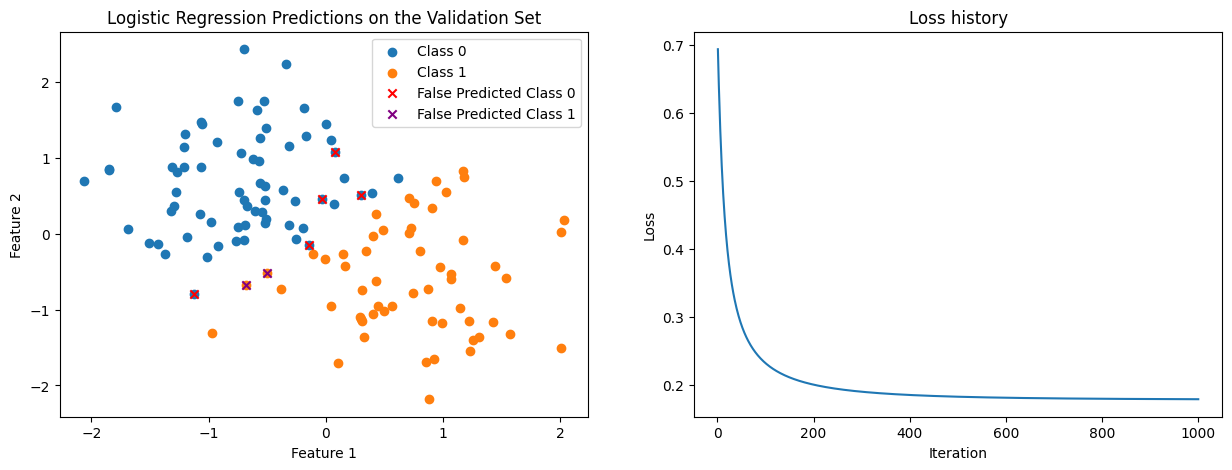

In [102]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

print("Accuracy (Training Set):", len(y_train[y_train == y_train_pred]) / len(y_train))
print("Accuracy (Validation Set):", len(y_valid[y_valid == y_valid_pred]) / len(y_valid))

_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(X_valid[:, 1][y_valid_pred == 0], X_valid[:, 2][y_valid_pred == 0], label=r"Class 0")
ax[0].scatter(X_valid[:, 1][y_valid_pred == 1], X_valid[:, 2][y_valid_pred == 1], label=r"Class 1")

ax[0].scatter(X_valid[:, 1][(y_valid_pred == 0) & (y_valid_pred != y_valid)], 
            X_valid[:, 2][(y_valid_pred == 0) & (y_valid_pred != y_valid)], 
            label=r"False Predicted Class 0", marker='x', color='red')

ax[0].scatter(X_valid[:, 1][(y_valid_pred == 1) & (y_valid_pred != y_valid)], 
            X_valid[:, 2][(y_valid_pred == 1) & (y_valid_pred != y_valid)], 
            label=r"False Predicted Class 1", marker='x', color='purple')

ax[0].set_title(r'Logistic Regression Predictions on the Validation Set')
ax[0].set_xlabel(r'Feature 1')
ax[0].set_ylabel(r'Feature 2')
ax[0].legend()

ax[1].plot(np.arange(1, len(model.loss_hist) + 1), model.loss_hist)
ax[1].set_title(r'Loss history')
ax[1].set_xlabel(r'Iteration')
ax[1].set_ylabel(r'Loss')

plt.show()

**(Question)** Plot the decision boundary on top on the data points.

*Hint*: to compute the decision boundary, start from its equation and transform it to an usual affine formulation.

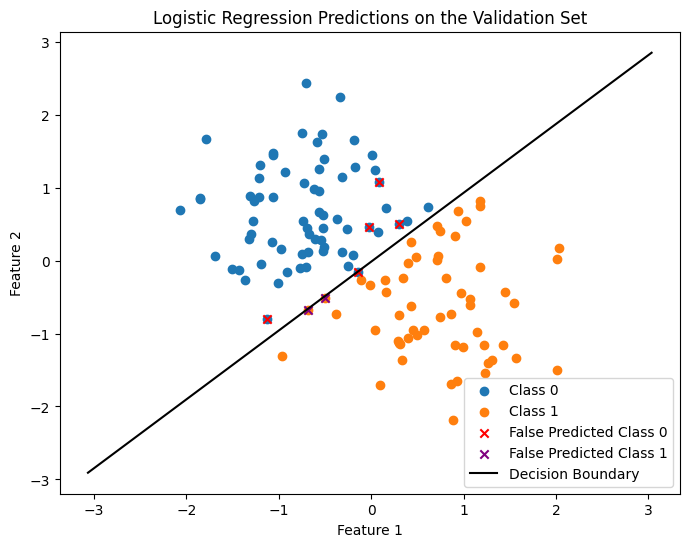

In [103]:
plt.figure(figsize=(8,6))

plt.scatter(X_valid[:, 1][y_valid_pred == 0], X_valid[:, 2][y_valid_pred == 0], label=r"Class 0")
plt.scatter(X_valid[:, 1][y_valid_pred == 1], X_valid[:, 2][y_valid_pred == 1], label=r"Class 1")

plt.scatter(X_valid[:, 1][(y_valid_pred == 0) & (y_valid_pred != y_valid)], 
            X_valid[:, 2][(y_valid_pred == 0) & (y_valid_pred != y_valid)], 
            label=r"False Predicted Class 0", marker='x', color='red')
plt.scatter(X_valid[:, 1][(y_valid_pred == 1) & (y_valid_pred != y_valid)], 
            X_valid[:, 2][(y_valid_pred == 1) & (y_valid_pred != y_valid)], 
            label=r"False Predicted Class 1", marker='x', color='purple')

x1_range = np.linspace(X_valid[:, 1].min() - 1, X_valid[:, 1].max() + 1, 100)
x2_range = -(model.w[1] * x1_range + model.w[0]) / model.w[2]
plt.plot(x1_range, x2_range, color='black', label=r'Decision Boundary')

plt.title(r'Logistic Regression Predictions on the Validation Set')
plt.xlabel(r'Feature 1')
plt.ylabel(r'Feature 2')

plt.legend()
plt.show()

**(Question)** Play around with the `learning_rate` and `n_iters` hyperparameters to see the impact on gradient descent convergence.
Plot the evolution of the loss over the iterations for different learning rates.
Comment the results.

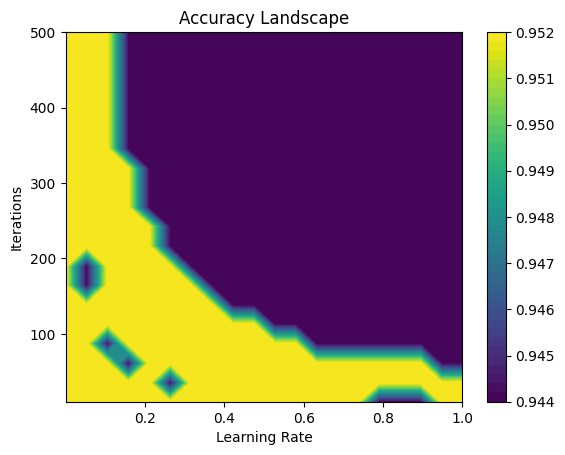

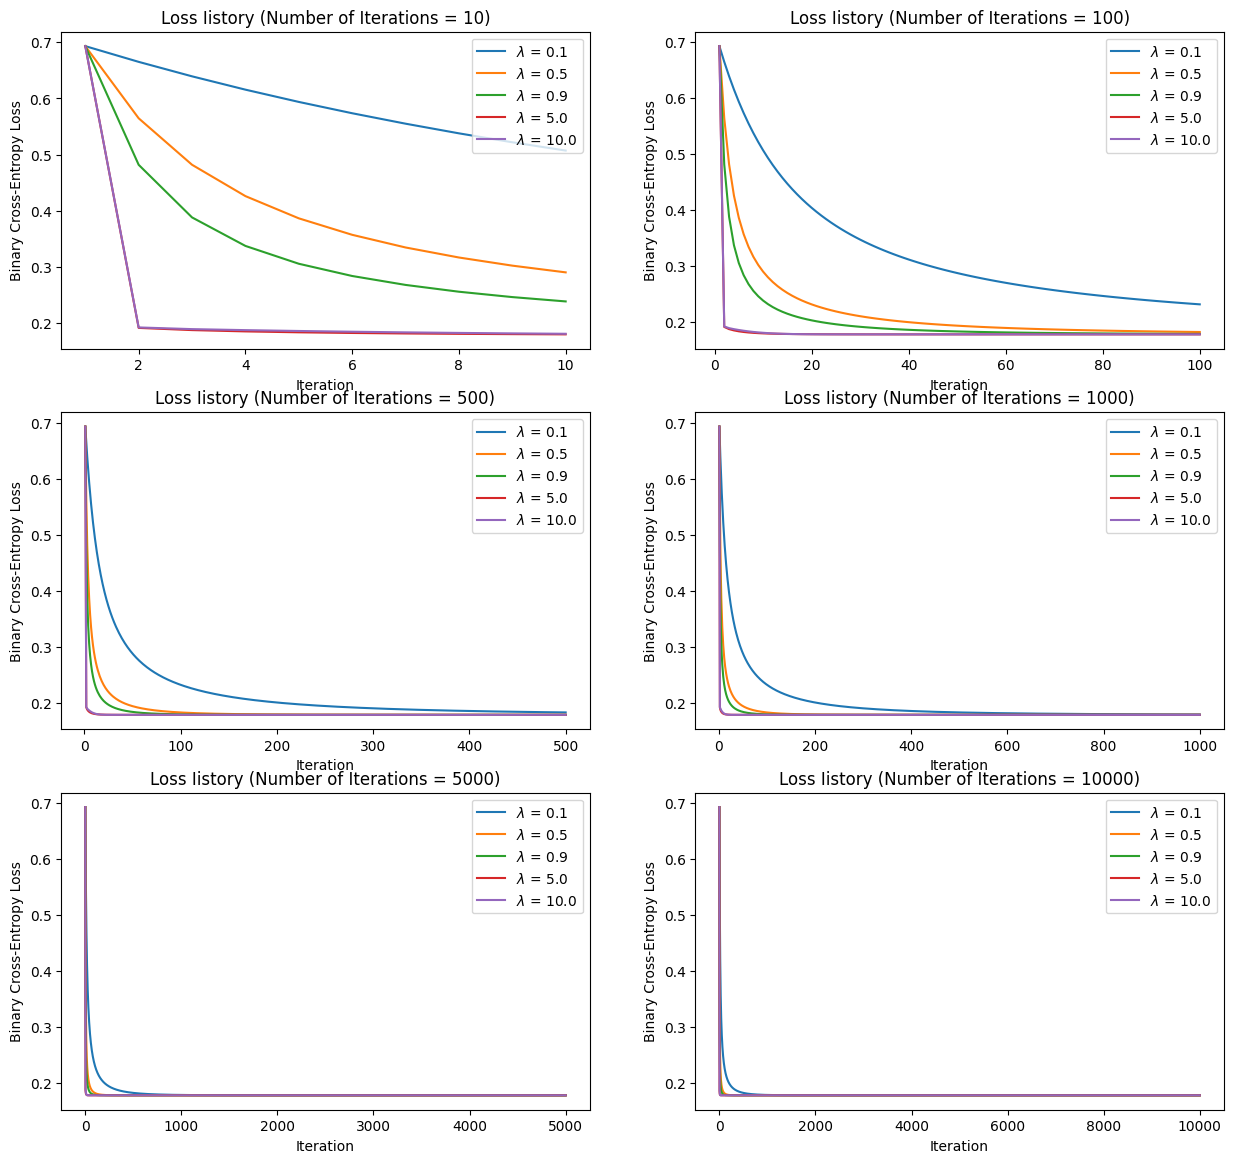

In [104]:
def logistic_regression_accuracy(lambd, iter):
    model = LogisticRegression(lambd, iter)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return len(y_valid[y_valid == y_pred]) / len(y_valid)

lambd_landscape = np.linspace(1e-10, 1, 20)
iter_landscape = np.linspace(10, 500, 20, dtype=int)
z_loss_landscape = np.array([[logistic_regression_accuracy(lambd, iter) for lambd in lambd_landscape] for iter in iter_landscape])

plt.contourf(lambd_landscape, iter_landscape, z_loss_landscape, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel(r'Learning Rate')
plt.ylabel(r'Iterations')
plt.title(r'Accuracy Landscape')

_, ax = plt.subplots(3, 2, figsize=(15, 14))
lam = [0.1, 0.5, 0.9, 5., 10.]
iter = [10, 100, 500, 1000, 5000, 10000]

for i in range(len(iter)):
    for learning_rate in lam:            
        model = LogisticRegression(learning_rate, iter[i])
        model.fit(X_train, y_train)
        
        row = i // 2
        col = i % 2
        ax[row, col].plot(np.arange(1, len(model.loss_hist) + 1), model.loss_hist, label=rf'$\lambda$ = {learning_rate}')

    ax[row, col].set_title(rf'Loss Iistory (Number of Iterations = {iter[i]})')
    ax[row, col].set_xlabel(r'Iteration')
    ax[row, col].set_ylabel(r'Binary Cross-Entropy Loss')
    ax[row, col].legend()
        
plt.show()

* Increase the number of iterations will lead to convergence, whatever the learning rate

* In this case, increasing the learning rate accelerates the convergence and don't lead to divergence. But we tried with 50 and 100 and we can observe divergence (see next plot).

* We see that in each case, the "best" learning rate reach a plateau at a value of the BCE a bit under 0.2. So it is expected that we cannot reach a lower BCE.

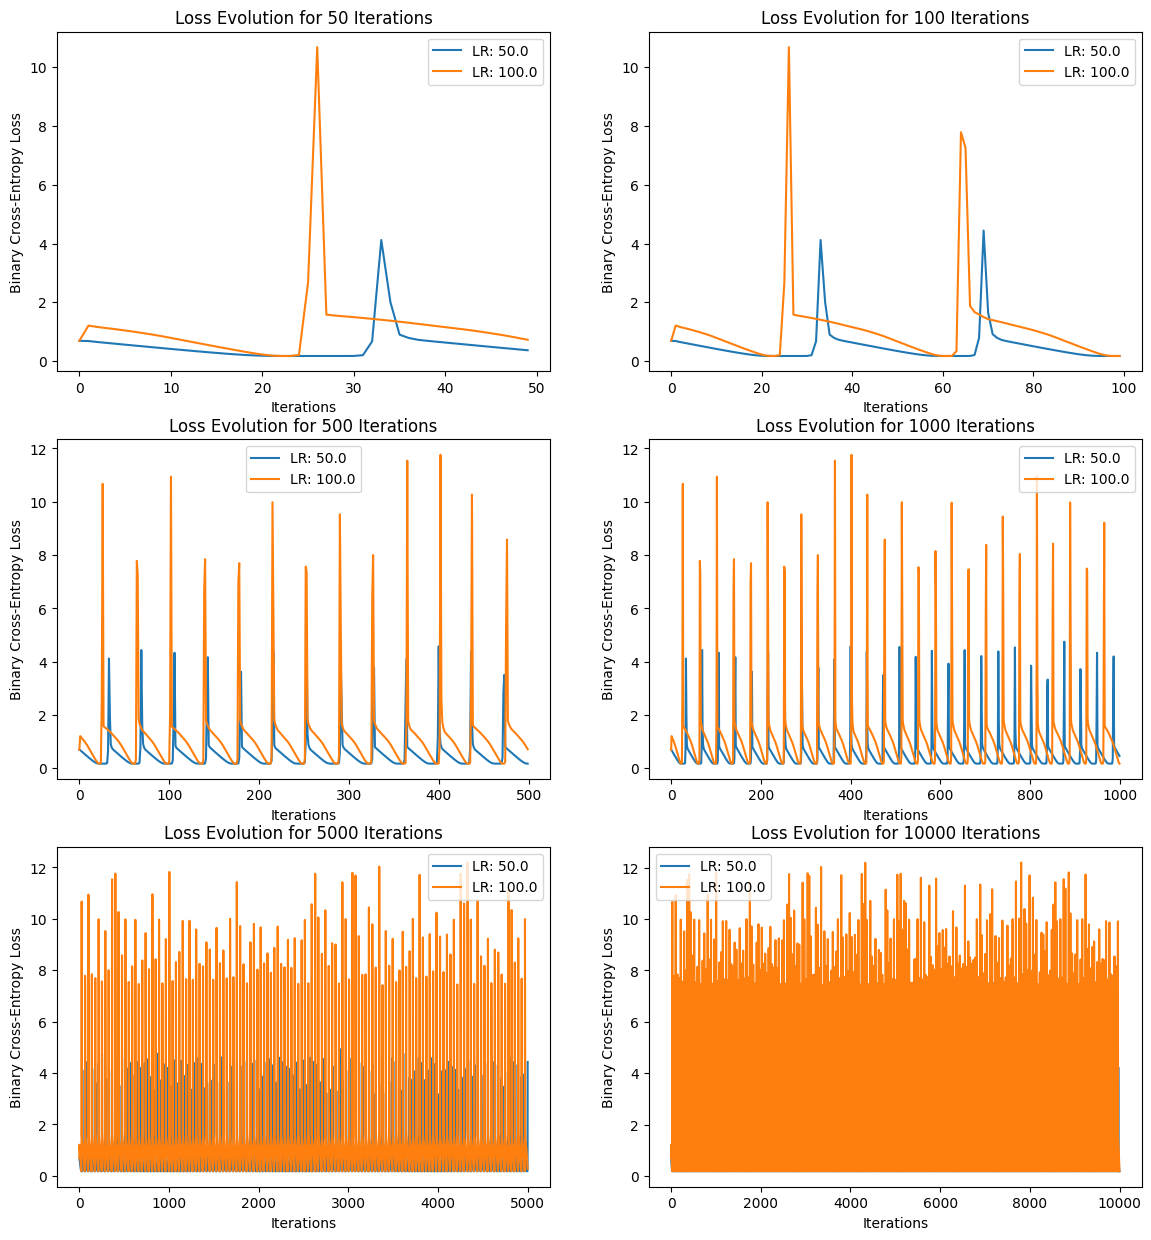

In [105]:
# Vizualization of the divergence with higher learning rates
learning_rates = [50., 100.]
n_iters = [50, 100, 500, 1000, 5000, 10000]

fig, ax = plt.subplots(3, 2, figsize=(14, 15))

for i in range(len(n_iters)):
    for lr in learning_rates:
        logReg = LogisticRegression(learning_rate=lr, n_iters=n_iters[i])
        logReg.fit(X_train, y_train)

        row = i // 2
        col = i % 2

        ax[row, col].plot(logReg.loss_hist, label=f'LR: {lr}')
        ax[row, col].set_title(fr'Loss Evolution for {n_iters[i]} Iterations')
        ax[row, col].set_xlabel(r'Iterations')
        ax[row, col].set_ylabel(r'Binary Cross-Entropy Loss')
        ax[row, col].legend(loc='best')

plt.show()

### 3. Gaussian generative model

**(Question)** Complete the `GaussianGenerativeModel` class below.

In [106]:
class GaussianGenerativeModel():
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}
        self.means = {}
        self.vars = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = np.mean(X_c, axis=0)
            self.vars[c] = np.var(X_c, axis=0)
    
    def predict(self, X):
        posteriors = []
        
        for x in X:
            class_posteriors = []
            for c in self.classes:
                epsilon = 1e-15
                prior = np.log(self.priors[c])
                likelihood = np.sum(
                    np.log(self.gaussian_likelihood(c, x) + epsilon)
                )
                posterior = prior + likelihood
                class_posteriors.append(posterior)
            
            posteriors.append(self.classes[np.argmax(class_posteriors)])
        
        return np.array(posteriors)
    
    def gaussian_likelihood(self, c, x):
        mean = self.means[c]
        var = self.vars[c] + 1e-15  # Add a small epsilon to avoid division by zero
        likelihoods = (1 / np.sqrt(2 * np.pi * var)) * np.exp(- (x - mean)**2 / (2 * var))
        return likelihoods

**(Question)** Apply your gaussian generative model to our synthetic dataset. Report the classification accuracy on the training and validation sets.

*Hint:* The column with ones is not needed for this model.

Accuracy (Training Set): 0.928
Accuracy (Validation Set): 0.96


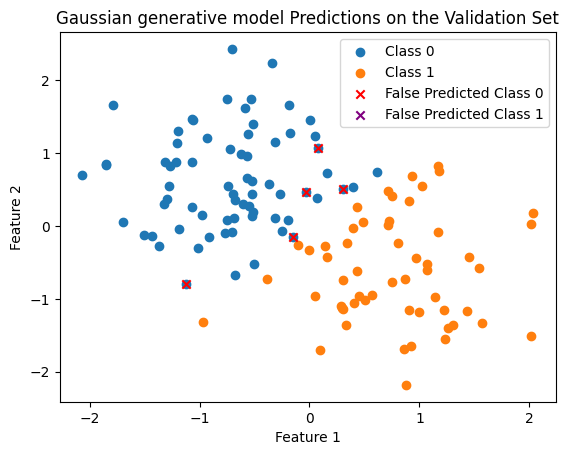

In [107]:
model = GaussianGenerativeModel()
model.fit(X_train[:, 1:], y_train)
y_train_pred = model.predict(X_train[:, 1:])
y_valid_pred = model.predict(X_valid[:, 1:])

print("Accuracy (Training Set):", len(y_train[y_train == y_train_pred]) / len(y_train))
print("Accuracy (Validation Set):", len(y_valid[y_valid == y_valid_pred]) / len(y_valid))

plt.scatter(X_valid[:, 1][y_valid_pred == 0], X_valid[:, 2][y_valid_pred == 0], label=r"Class 0")
plt.scatter(X_valid[:, 1][y_valid_pred == 1], X_valid[:, 2][y_valid_pred == 1], label=r"Class 1")

plt.scatter(X_valid[:, 1][(y_valid_pred == 0) & (y_valid_pred != y_valid)], 
            X_valid[:, 2][(y_valid_pred == 0) & (y_valid_pred != y_valid)], 
            label=r"False Predicted Class 0", marker='x', color='red')

plt.scatter(X_valid[:, 1][(y_valid_pred == 1) & (y_valid_pred != y_valid)], 
            X_valid[:, 2][(y_valid_pred == 1) & (y_valid_pred != y_valid)], 
            label=r"False Predicted Class 1", marker='x', color='purple')

plt.title(r'Gaussian generative model Predictions on the Validation Set')
plt.xlabel(r'Feature 1')
plt.ylabel(r'Feature 2')
plt.legend()
plt.show()

**(Question)** Plot the decision boundary on top on the data points and compare it with the one obtained with logistic regression.

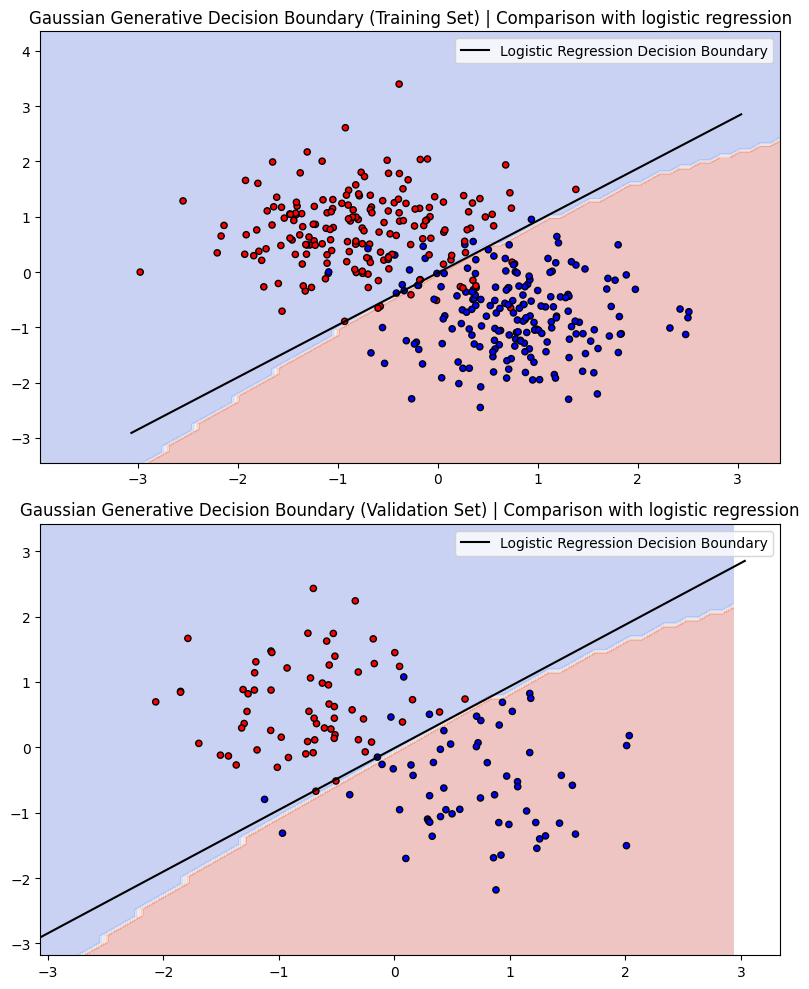

In [108]:
x_train_min, x_train_max = X_train[:, 1:][:, 0].min() - 1, X_train[:, 1:][:, 0].max() + 1
y_train_min, y_train_max = X_train[:, 1:][:, 1].min() - 1, X_train[:, 1:][:, 1].max() + 1
xx_train, yy_train = np.meshgrid(np.arange(x_train_min, x_train_max, 0.1),
                                 np.arange(y_train_min, y_train_max, 0.1))

x_valid_min, x_valid_max = X_valid[:, 1:][:, 0].min() - 1, X_valid[:, 1:][:, 0].max() + 1
y_valid_min, y_valid_max = X_valid[:, 1:][:, 1].min() - 1, X_valid[:, 1:][:, 1].max() + 1
xx_valid, yy_valid = np.meshgrid(np.arange(x_valid_min, x_valid_max, 0.1),
                                 np.arange(y_valid_min, y_valid_max, 0.1))

model = GaussianGenerativeModel()
model.fit(X_train[:, 1:], y_train)

_, ax = plt.subplots(2, 1, figsize=(8, 10))

Z = model.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z = Z.reshape(xx_train.shape)
ax[0].contourf(xx_train, yy_train, Z, alpha=0.3, cmap='coolwarm')
ax[0].scatter(X_train[:, 1:][:, 0], X_train[:, 1:][:, 1], c=y_train, s=20, edgecolor='k', cmap=ListedColormap(('red', 'blue')))
ax[0].plot(x1_range, x2_range, color='black', label=r'Logistic Regression Decision Boundary')
ax[0].set_title(r"Gaussian Generative Decision Boundary (Training Set) | Comparison with logistic regression")
ax[0].legend()

Z = model.predict(np.c_[xx_valid.ravel(), yy_valid.ravel()])
Z = Z.reshape(xx_valid.shape)
ax[1].contourf(xx_valid, yy_valid, Z, alpha=0.3, cmap='coolwarm')
ax[1].scatter(X_valid[:, 1:][:, 0], X_valid[:, 1:][:, 1], c=y_valid, s=20, edgecolor='k', cmap=ListedColormap(('red', 'blue')))
ax[1].plot(x1_range, x2_range, color='black', label=r'Logistic Regression Decision Boundary')
ax[1].set_title(r"Gaussian Generative Decision Boundary (Validation Set) | Comparison with logistic regression")
ax[1].legend()

plt.tight_layout()
plt.show()

### 4. Comparison with `sklearn`

**(Question)** Apply logistic regression using the `LogisticRegression` class from the `scikit-learn` library. Compare the results with your previous implementation.

*Hints:*
- If your features are already augmented with a column of ones, set the `fit_intercept` parameter to `False`
- Set `penalty` (regularization to `None` to match your unregularized implementation

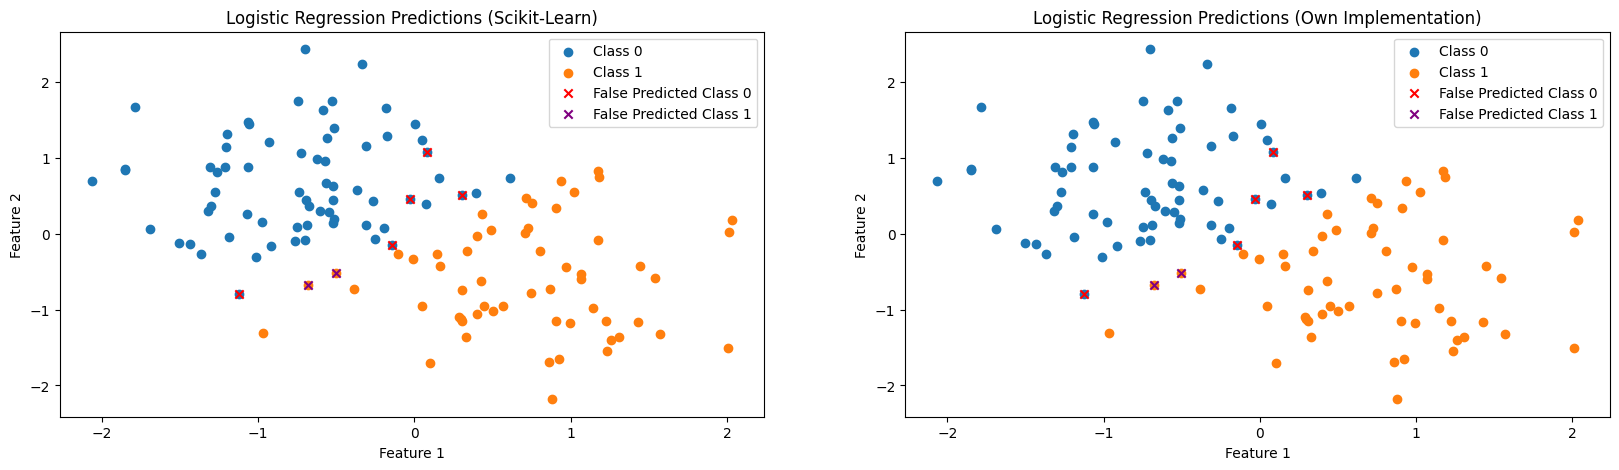

In [109]:
sklearn_model = LogisticRegressionSklearn(penalty=None, fit_intercept=False, max_iter=1000)
sklearn_model.fit(X_train, y_train)
y_sklearn_predict = sklearn_model.predict(X_valid)

model = LogisticRegression()
model.fit(X_train, y_train)
y_predict = model.predict(X_valid)

_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(X_valid[:, 1][y_sklearn_predict == 0], X_valid[:, 2][y_sklearn_predict == 0], label=r"Class 0")
ax[0].scatter(X_valid[:, 1][y_sklearn_predict == 1], X_valid[:, 2][y_sklearn_predict == 1], label=r"Class 1")

ax[0].scatter(X_valid[:, 1][(y_sklearn_predict == 0) & (y_sklearn_predict != y_valid)], 
            X_valid[:, 2][(y_sklearn_predict == 0) & (y_sklearn_predict != y_valid)], 
            label=r"False Predicted Class 0", marker='x', color='red')

ax[0].scatter(X_valid[:, 1][(y_sklearn_predict == 1) & (y_sklearn_predict != y_valid)], 
            X_valid[:, 2][(y_sklearn_predict == 1) & (y_sklearn_predict != y_valid)], 
            label=r"False Predicted Class 1", marker='x', color='purple')

ax[0].set_title(r'Logistic Regression Predictions (Scikit-Learn)')
ax[0].set_xlabel(r'Feature 1')
ax[0].set_ylabel(r'Feature 2')
ax[0].legend()

ax[1].scatter(X_valid[:, 1][y_predict == 0], X_valid[:, 2][y_predict == 0], label=r"Class 0")
ax[1].scatter(X_valid[:, 1][y_predict == 1], X_valid[:, 2][y_predict == 1], label=r"Class 1")

ax[1].scatter(X_valid[:, 1][(y_predict == 0) & (y_predict != y_valid)], 
            X_valid[:, 2][(y_predict == 0) & (y_predict != y_valid)], 
            label=r"False Predicted Class 0", marker='x', color='red')

ax[1].scatter(X_valid[:, 1][(y_predict == 1) & (y_predict != y_valid)], 
            X_valid[:, 2][(y_predict == 1) & (y_predict != y_valid)], 
            label=r"False Predicted Class 1", marker='x', color='purple')

ax[1].set_title(r'Logistic Regression Predictions (Own Implementation)')
ax[1].set_xlabel(r'Feature 1')
ax[1].set_ylabel(r'Feature 2')
ax[1].legend()

plt.show()

* We see that we have the same accuracy for both model, which is a good sign that our implementation is the same as the one implemented in sklearn.

* Looking at the plot, we see that we have the same points that are misclassified by both models.

### 5. Application to breast cancer dataset

In [110]:
dataset = load_breast_cancer(as_frame=True)

**(Question)** Load the data into `X` and `y` variables. Familiarize yourself with this dataset. What are the dimensions? Explain what they mean.

In [111]:
X = dataset.data
y = dataset.target

X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [112]:
y.describe()

count    569.000000
mean       0.627417
std        0.483918
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

In [113]:
y.value_counts()

target
1    357
0    212
Name: count, dtype: int64

* X contains the different features of the patients, with a value associated to each.

* y contains the state of the patient (i.e., if he has or not a breast cancer), encoded in a binary way (0 if no cancer and 1 if cancer).

**(Question)** Split into train/test and preprocess the data.

In [114]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

means = X_train.mean(axis=0)
stds = X_train.std(axis=0)

X_train = (X_train - means) / stds
X_valid = (X_valid - means) / stds

X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

X_log_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_log_valid = np.column_stack((np.ones(X_valid.shape[0]), X_valid))

**(Question)** Apply your implementations of logistic regression and gaussian generative model to this dataset.

In [115]:
logistic = LogisticRegression()
gaussian = GaussianGenerativeModel()

logistic.fit(X_log_train, y_train)
gaussian.fit(X_train, y_train)

y_log_pred = logistic.predict(X_log_valid)
y_gau_pred = gaussian.predict(X_valid)

print("Accuracy (Logistic):", len(y_valid[y_valid == y_log_pred]) / len(y_valid))
print("Accuracy (Gaussian):", len(y_valid[y_valid == y_gau_pred]) / len(y_valid))

Accuracy (Logistic): 0.993006993006993
Accuracy (Gaussian): 0.951048951048951


**(Question)** Apply cross-validation (see `sklearn.model_selection`) on your implementations to successively train several models and obtain predictions for the whole dataset.
Comment the results.


3-Fold Cross-Validation Results:
Logistic Regression Average Accuracy with 3-Folds: 0.9765258215962441
Gaussian Generative Average Accuracy with 3-Folds: 0.92018779342723

5-Fold Cross-Validation Results:
Logistic Regression Average Accuracy with 5-Folds: 0.9717647058823531
Gaussian Generative Average Accuracy with 5-Folds: 0.931764705882353

8-Fold Cross-Validation Results:
Logistic Regression Average Accuracy with 8-Folds: 0.9740566037735849
Gaussian Generative Average Accuracy with 8-Folds: 0.9292452830188679

10-Fold Cross-Validation Results:
Logistic Regression Average Accuracy with 10-Folds: 0.9690476190476189
Gaussian Generative Average Accuracy with 10-Folds: 0.9285714285714286

13-Fold Cross-Validation Results:
Logistic Regression Average Accuracy with 13-Folds: 0.96875
Gaussian Generative Average Accuracy with 13-Folds: 0.9278846153846154

15-Fold Cross-Validation Results:
Logistic Regression Average Accuracy with 15-Folds: 0.9738095238095238
Gaussian Generative Average Accu

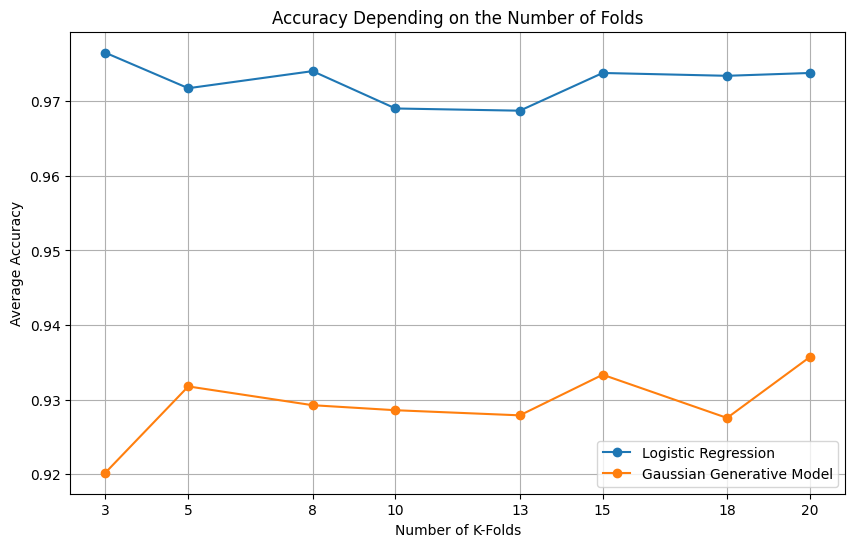

In [116]:
def k_fold_cross_validation(X, y, model_class, k=5):
    n_samples = X.shape[0]
    fold_size = n_samples // k
    accuracies = []
    
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for fold in range(k):
        start, end = fold * fold_size, (fold + 1) * fold_size
        valid_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])
        
        X_train, y_train = X[train_indices], y[train_indices]
        X_valid, y_valid = X[valid_indices], y[valid_indices]
    
        model = model_class()
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_valid)
        accuracy = np.mean(y_pred == y_valid)
        accuracies.append(accuracy)
    
    avg_accuracy = np.mean(accuracies)
    return avg_accuracy

k_values = [3, 5, 8, 10, 13, 15, 18, 20]
log_reg_accuracies = []
gaussian_gen_accuracies = []

for k in k_values:
    print(f"\n{k}-Fold Cross-Validation Results:")

    log_reg_accuracy = k_fold_cross_validation(X_log_train, y_train, LogisticRegression, k=k)
    log_reg_accuracies.append(log_reg_accuracy)
    print(f"Logistic Regression Average Accuracy with {k}-Folds: {log_reg_accuracy}")

    gaussian_gen_accuracy = k_fold_cross_validation(X_log_train, y_train, GaussianGenerativeModel, k=k)
    gaussian_gen_accuracies.append(gaussian_gen_accuracy)
    print(f"Gaussian Generative Average Accuracy with {k}-Folds: {gaussian_gen_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, log_reg_accuracies, marker='o', label=r'Logistic Regression')
plt.plot(k_values, gaussian_gen_accuracies, marker='o', label=r'Gaussian Generative Model')
plt.title(r'Accuracy Depending on the Number of Folds')
plt.xlabel(r'Number of K-Folds')
plt.ylabel(r'Average Accuracy')
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()

* Looking at the plot, we can observe that the general accuracy is quiet high, with value between $92$ and $98 \%$, whatever the number of folds or the model used.

* On this dataset, we can see that the Logistic Regression performs better than the Gaussian Generative Model whatever the number of folds. This result can be explain by the fact that the data are probably not distributed like a Gaussian Distribution and more generally, because it does not make any assumptions about the distribution of the data, making the Logistic Regression working better on high-dimensional data.

* Looking at the evolution of the accuracy depending on the number of folds, it stays mainly constant because the same dataset is used in each split, providing representative samples each time. Variations in fold size do not significantly impact model performance, and if the model generalizes well, accuracy remains stable across different splits.